In [1]:
import math

from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer, EntangledLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


{'noise_model': <NoiseModel on []>, 'device': 'CPU', 'max_parallel_experiments': 0, 'max_job_size': 16}


/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


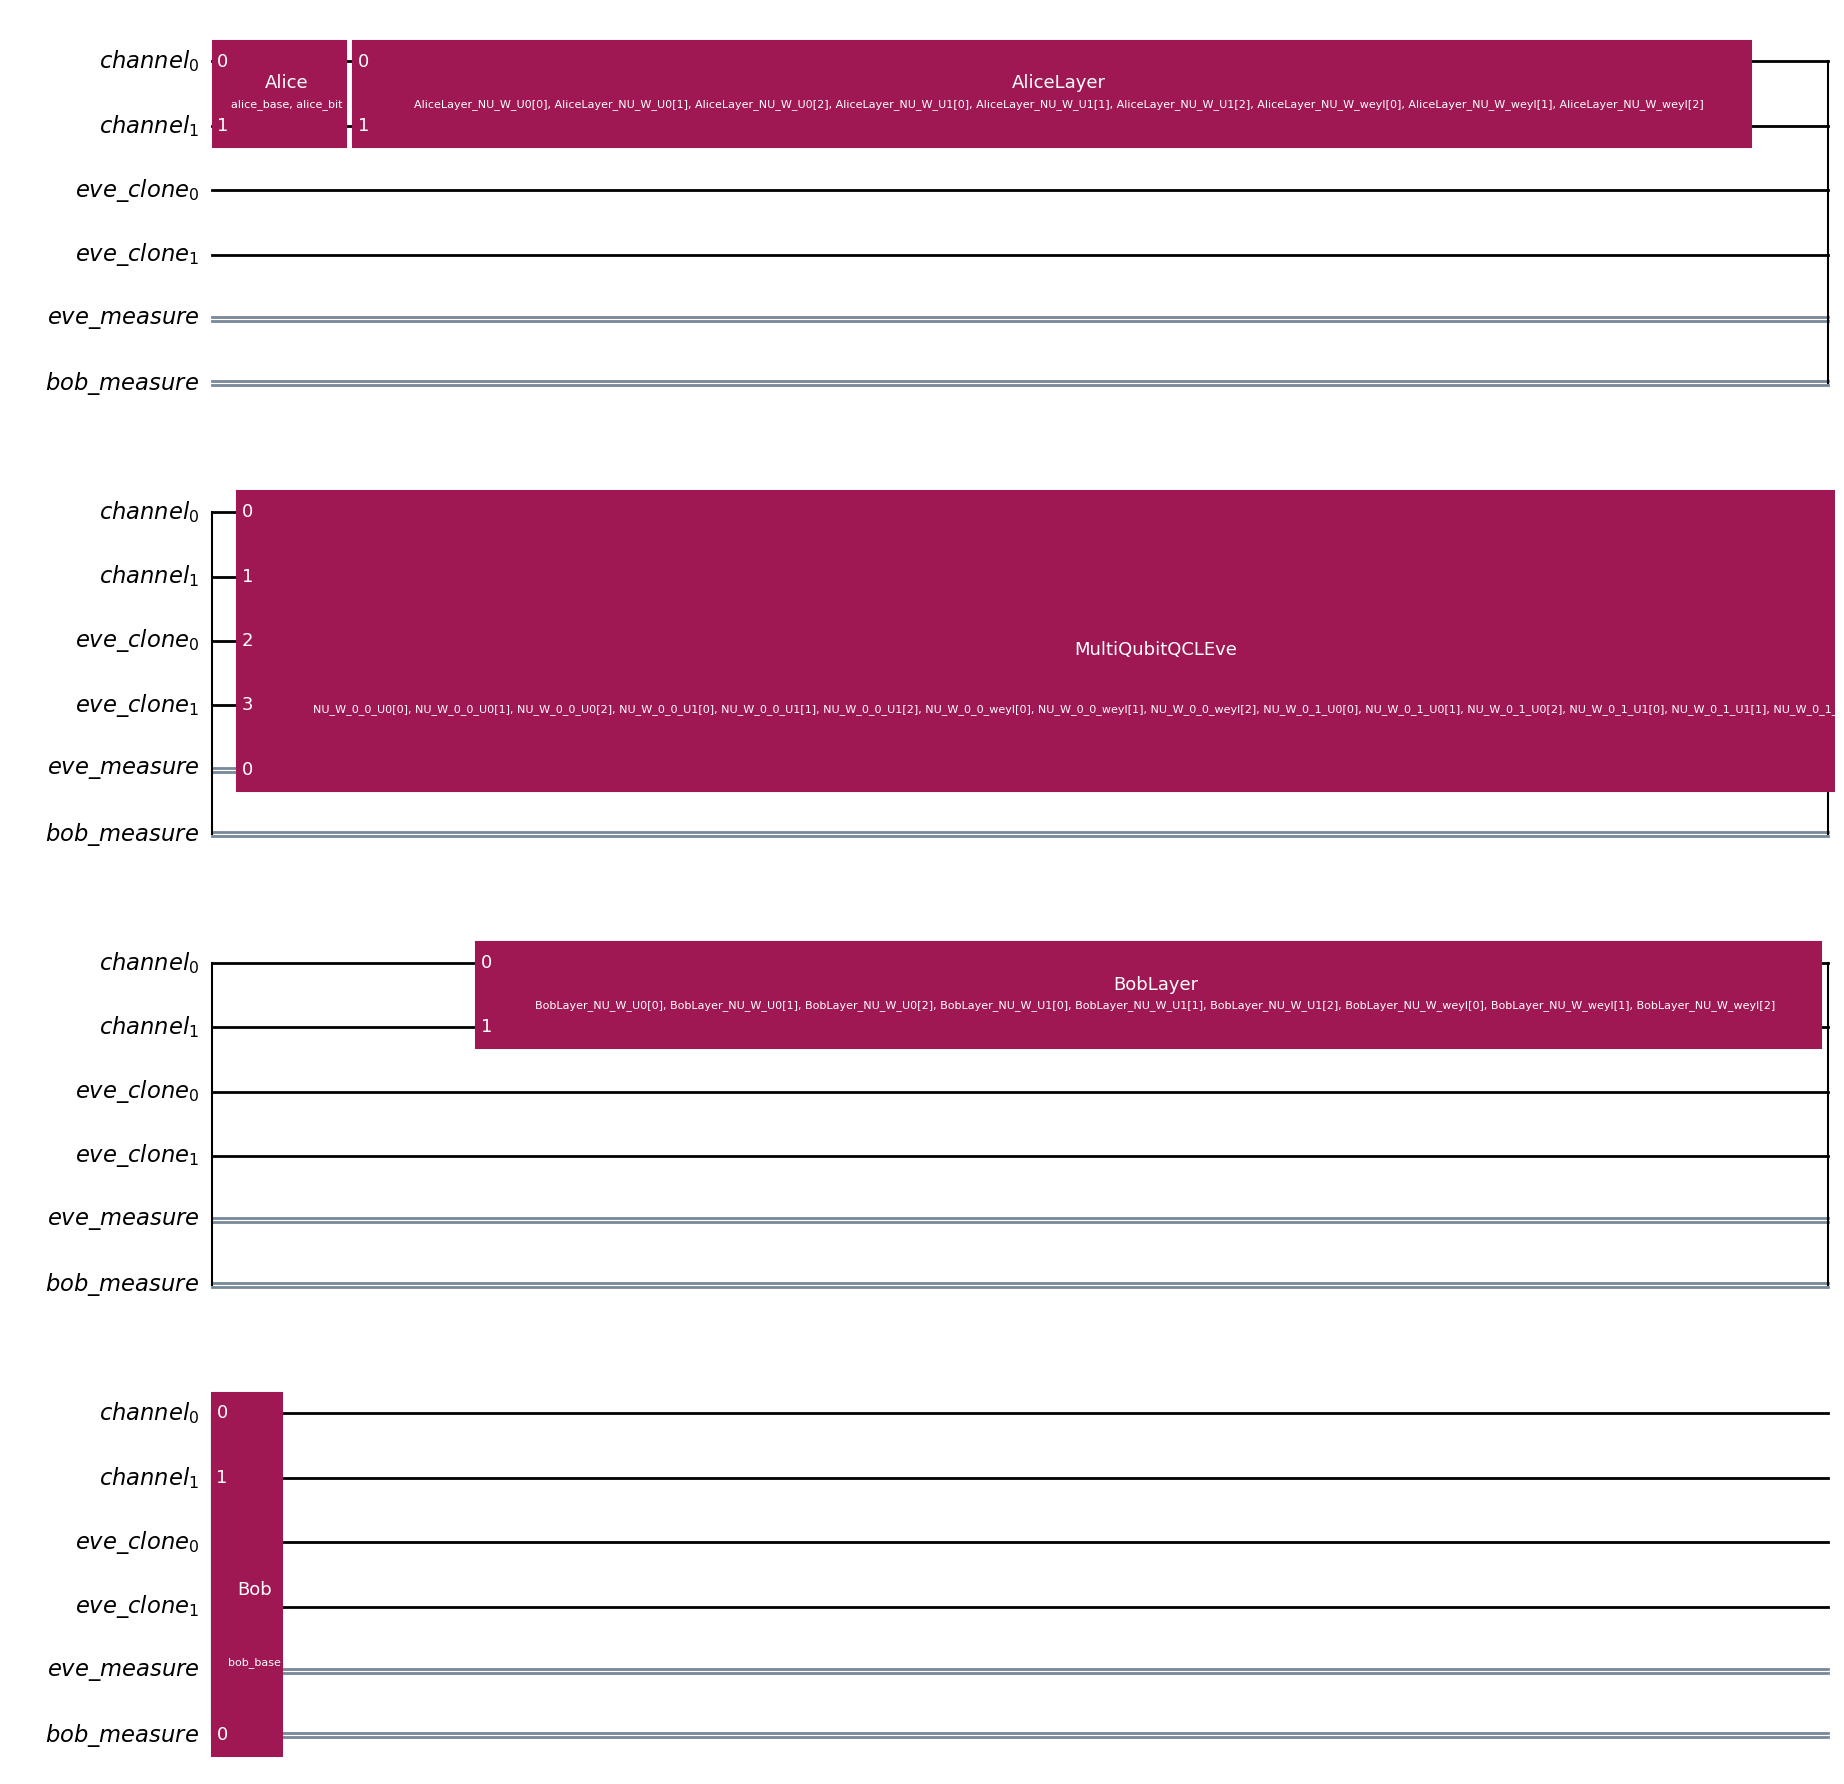

In [2]:
layers = [EntangledLayer("AliceLayer"), EntangledLayer("BobLayer")]
eve = MultiQubitQCLEve()

protocol = BB84EveTrainableProtocol(n_bits=128, elements=[layers[0], eve, layers[1]], channel_size=2,
                                        seed=0, alpha=100, learning_rate=0.01)
print(protocol._estimator.options.backend_options)

qc, _ = protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [3]:
def train():
    bob_qber, eve_qber = [], []
    qber = protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    for epoch in range(50):
        loss = protocol.train()
        qber = protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')

    return bob_qber, eve_qber

In [4]:
params = protocol.get_all_parameters()
# Wszystko na identity
for k, v in params.items():
    params[k] = 0.0

# Alice layer na swap
for p in layers[0].nu.uu_layers[0][0].weyl.params():
    k = p.name
    params[k] = math.pi / 2

# Bob layer na swap
for p in layers[1].nu.uu_layers[0][0].weyl.params():
    k = p.name
    params[k] = math.pi / 2

# Drugi weyl eve na swap
for p in eve.nu.uu_layers[1][0].weyl.params():
    k = p.name
    params[k] = math.pi / 2

print(params)

protocol.set_parameters(params)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


{'AliceLayer_NU_W_U0[0]': 0.0, 'AliceLayer_NU_W_U0[1]': 0.0, 'AliceLayer_NU_W_U0[2]': 0.0, 'AliceLayer_NU_W_U1[0]': 0.0, 'AliceLayer_NU_W_U1[1]': 0.0, 'AliceLayer_NU_W_U1[2]': 0.0, 'AliceLayer_NU_W_weyl[0]': 1.5707963267948966, 'AliceLayer_NU_W_weyl[1]': 1.5707963267948966, 'AliceLayer_NU_W_weyl[2]': 1.5707963267948966, 'NU_W_0_0_U0[0]': 0.0, 'NU_W_0_0_U0[1]': 0.0, 'NU_W_0_0_U0[2]': 0.0, 'NU_W_0_0_U1[0]': 0.0, 'NU_W_0_0_U1[1]': 0.0, 'NU_W_0_0_U1[2]': 0.0, 'NU_W_0_0_weyl[0]': 0.0, 'NU_W_0_0_weyl[1]': 0.0, 'NU_W_0_0_weyl[2]': 0.0, 'NU_W_0_1_U0[0]': 0.0, 'NU_W_0_1_U0[1]': 0.0, 'NU_W_0_1_U0[2]': 0.0, 'NU_W_0_1_U1[0]': 0.0, 'NU_W_0_1_U1[1]': 0.0, 'NU_W_0_1_U1[2]': 0.0, 'NU_W_0_1_weyl[0]': 0.0, 'NU_W_0_1_weyl[1]': 0.0, 'NU_W_0_1_weyl[2]': 0.0, 'NU_W_1_0_U0[0]': 0.0, 'NU_W_1_0_U0[1]': 0.0, 'NU_W_1_0_U0[2]': 0.0, 'NU_W_1_0_U1[0]': 0.0, 'NU_W_1_0_U1[1]': 0.0, 'NU_W_1_0_U1[2]': 0.0, 'NU_W_1_0_weyl[0]': 1.5707963267948966, 'NU_W_1_0_weyl[1]': 1.5707963267948966, 'NU_W_1_0_weyl[2]': 1.570796326794

/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


# Krok 1 - trenowanie całego obwodu
Uczymy cały obwód z docelową dokładnością Boba 0.853 (wartość kompromisowa w PCCM pomiędzy dokładnością Boba i Eve)

In [5]:
protocol.f_value = 0.853
b_q, e_q = train()

KeyboardInterrupt: 

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

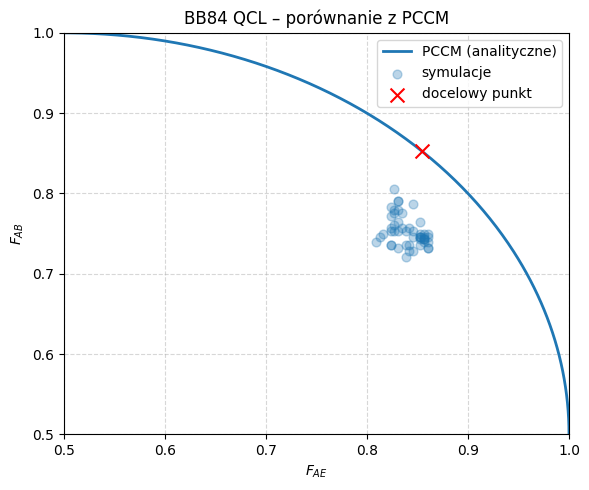

In [5]:
plt_fab_fae(b_q, e_q, 0.853)

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8

In [6]:
protocol.freeze_elements(layers)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [7]:
protocol.f_value = 0.8
b_q, e_q = train()

epoch: 0, loss: -0.796973466873169, QBER: {'bob_qber': np.float64(0.2279411764705882), 'eve_qber': np.float64(0.13235294117647056)}
epoch: 5, loss: -0.8218824863433838, QBER: {'bob_qber': np.float64(0.19852941176470584), 'eve_qber': np.float64(0.15808823529411764)}
epoch: 10, loss: -0.8272013068199158, QBER: {'bob_qber': np.float64(0.25), 'eve_qber': np.float64(0.15441176470588236)}
epoch: 15, loss: -0.8226490616798401, QBER: {'bob_qber': np.float64(0.25), 'eve_qber': np.float64(0.15441176470588236)}
epoch: 20, loss: -0.829750657081604, QBER: {'bob_qber': np.float64(0.25), 'eve_qber': np.float64(0.13970588235294112)}
epoch: 25, loss: -0.8289696574211121, QBER: {'bob_qber': np.float64(0.24632352941176472), 'eve_qber': np.float64(0.15073529411764708)}
epoch: 30, loss: -0.8242186307907104, QBER: {'bob_qber': np.float64(0.23529411764705888), 'eve_qber': np.float64(0.12867647058823528)}
epoch: 35, loss: -0.8240185976028442, QBER: {'bob_qber': np.float64(0.2941176470588235), 'eve_qber': np.f

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

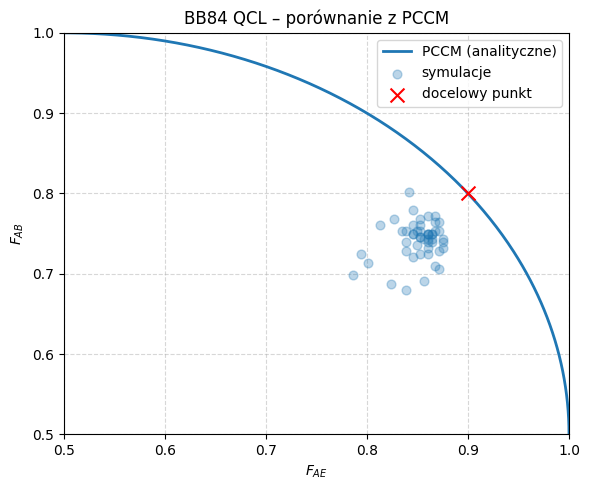

In [8]:
plt_fab_fae(b_q, e_q, 0.8)

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [9]:
protocol.freeze_elements([eve])

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [10]:
def bob_loss(target, mask, outputs):
    bob_Z = outputs["channel"][:, 0]

    sign = 1 - 2 * target.long()
    bob_f = 0.5 * (1 + sign * bob_Z)

    bob_f = bob_f[mask].mean()

    loss = -bob_f
    return loss


In [11]:
protocol.loss = bob_loss
b_q, e_q = train()

epoch: 0, loss: -0.7432714104652405, QBER: {'bob_qber': np.float64(0.30514705882352944), 'eve_qber': np.float64(0.16911764705882348)}
epoch: 5, loss: -0.7557426691055298, QBER: {'bob_qber': np.float64(0.2720588235294118), 'eve_qber': np.float64(0.2536764705882353)}
epoch: 10, loss: -0.7535560727119446, QBER: {'bob_qber': np.float64(0.27941176470588236), 'eve_qber': np.float64(0.2683823529411765)}
epoch: 15, loss: -0.7567747831344604, QBER: {'bob_qber': np.float64(0.2536764705882353), 'eve_qber': np.float64(0.2536764705882353)}
epoch: 20, loss: -0.753790557384491, QBER: {'bob_qber': np.float64(0.25735294117647056), 'eve_qber': np.float64(0.2904411764705882)}
epoch: 25, loss: -0.7556115388870239, QBER: {'bob_qber': np.float64(0.28308823529411764), 'eve_qber': np.float64(0.2904411764705882)}
epoch: 30, loss: -0.7581555843353271, QBER: {'bob_qber': np.float64(0.28308823529411764), 'eve_qber': np.float64(0.2867647058823529)}
epoch: 35, loss: -0.7553151845932007, QBER: {'bob_qber': np.float6

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

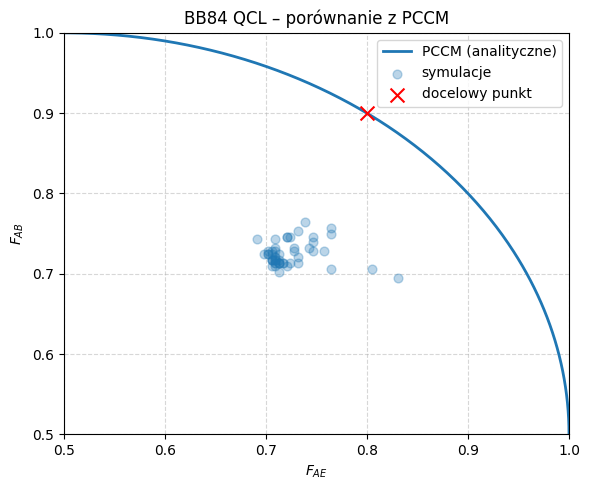

In [12]:
plt_fab_fae(b_q, e_q, 0.9)

# Końcowy obwód

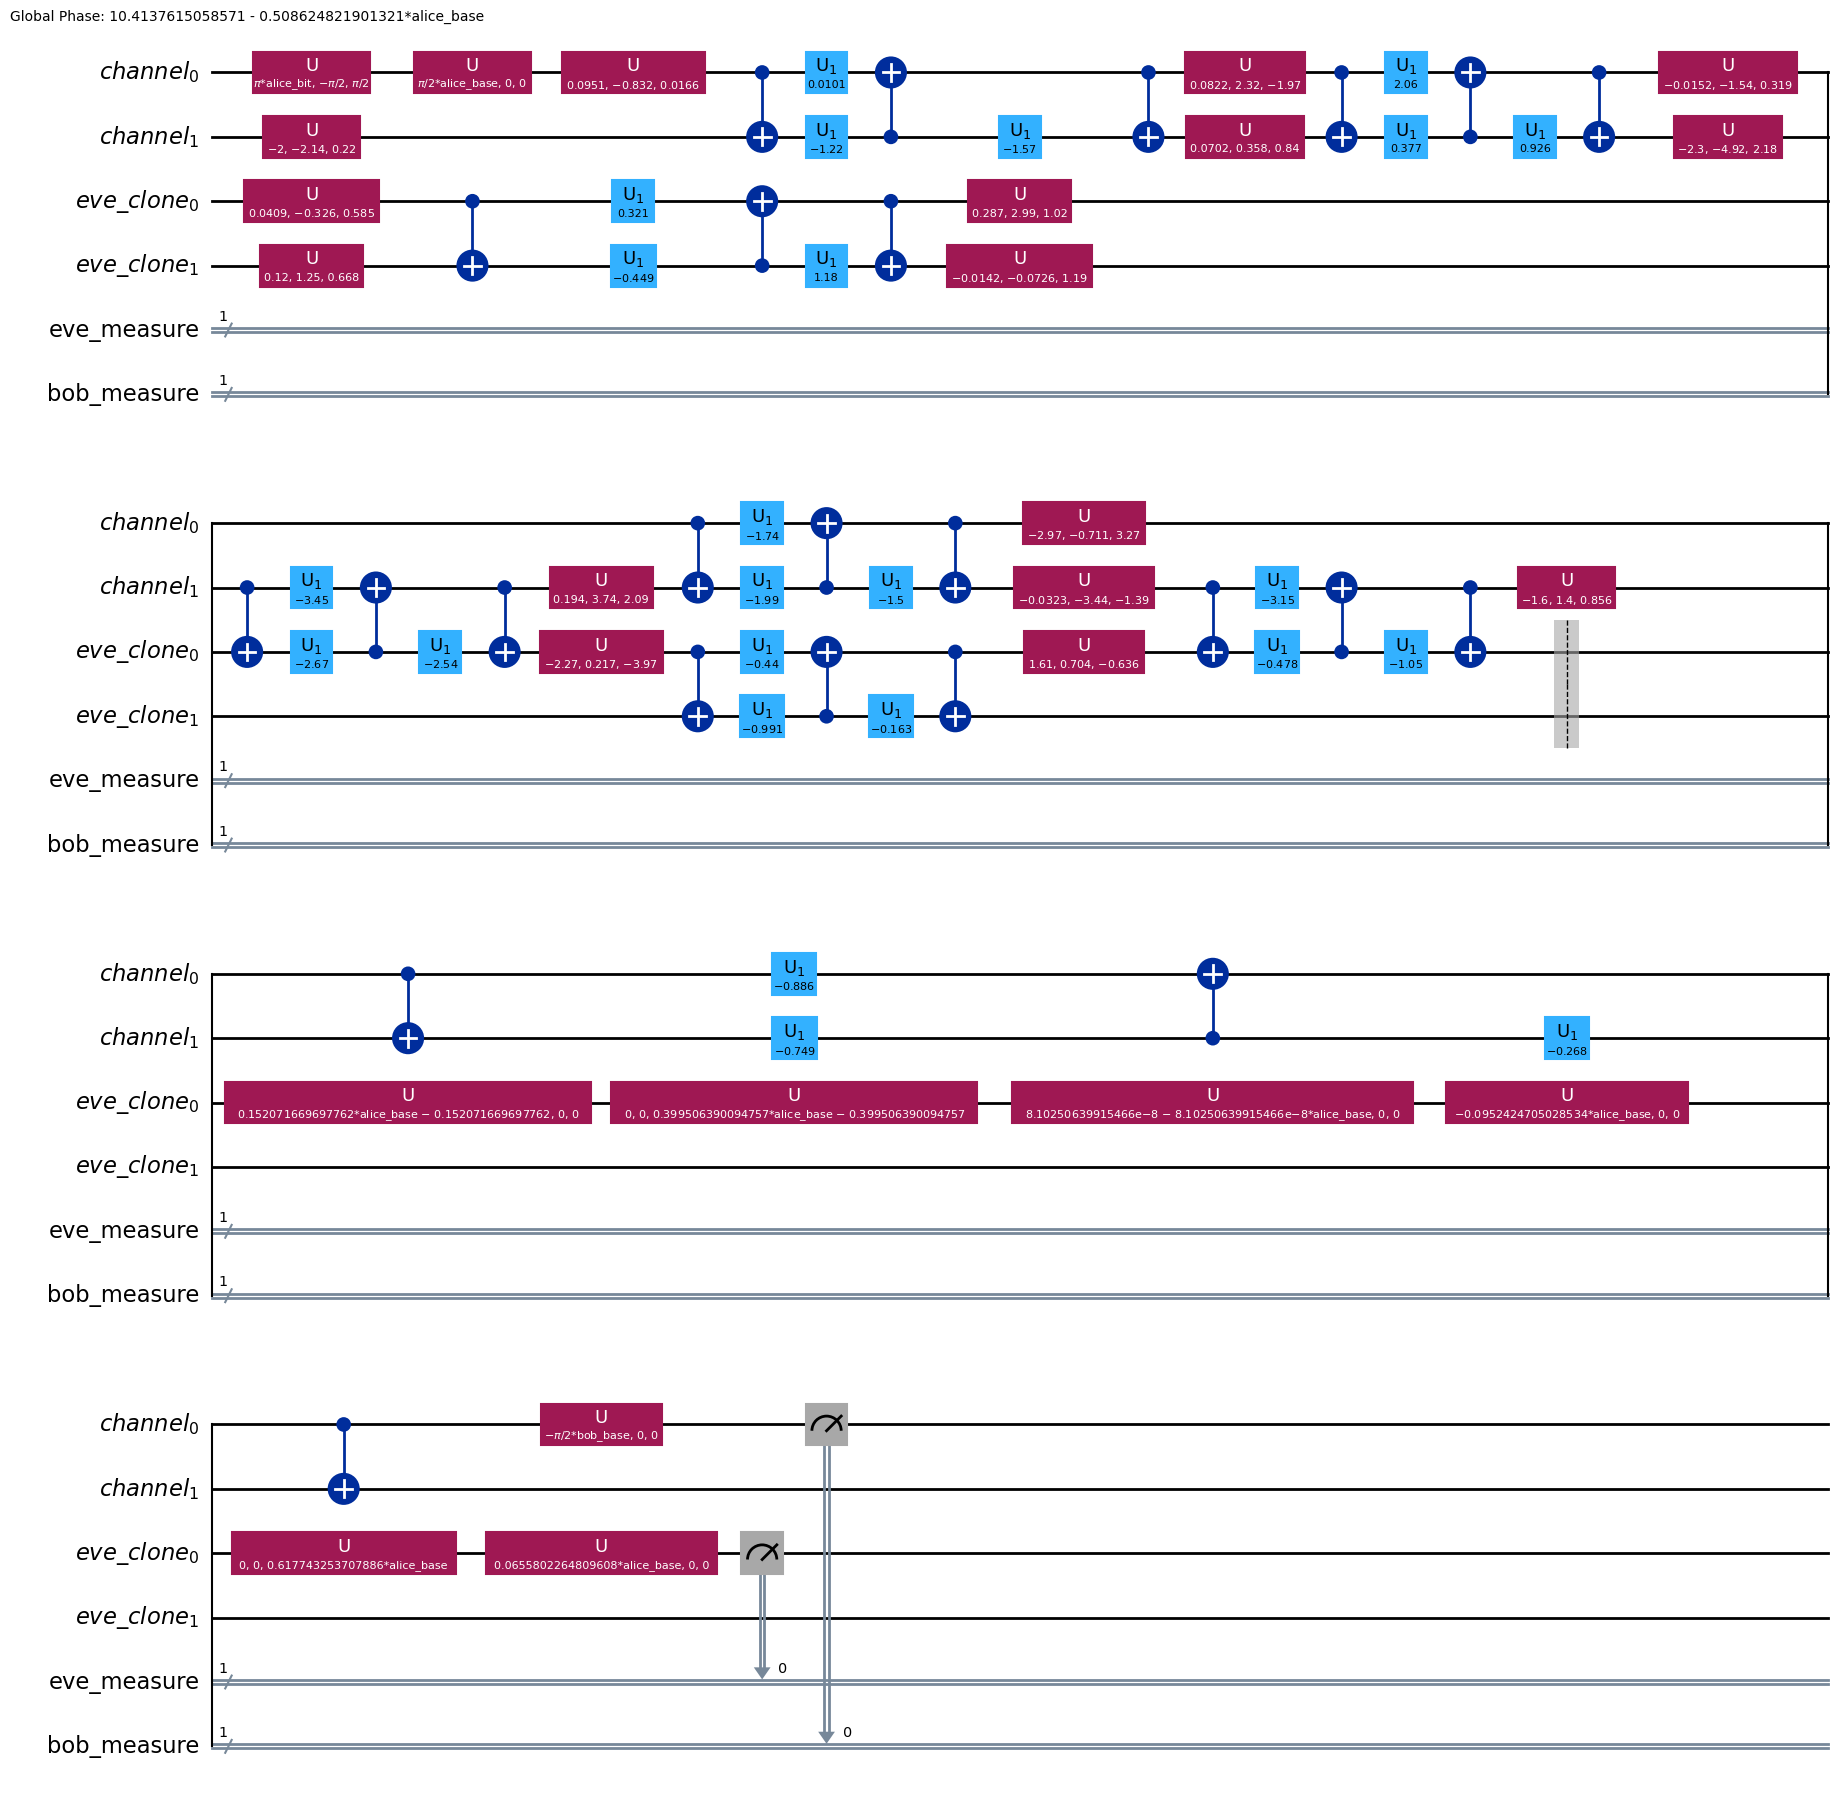

In [13]:
protocol._qc.assign_parameters(protocol.get_all_parameters()).draw("mpl")